In [24]:
import cv2 as cv
import matplotlib.pyplot as plt
import sys
import torch


In [25]:
sys.argv = [
    '', 
    '--dataset', '/Users/durutandogan/KITE/unet/duke_original',
    '--list_dir', '/Users/durutandogan/KITE/unet/contains_lesion',
    '--num_class', '2',  
    '--num_epochs', '50',
    '--batch_size', '4',
    '--fold', '1',
    '--run', '1',
    '--loss_dice' 
]

In [26]:
import unet_duke

In [13]:
image = cv.imread("/Users/durutandogan/Desktop/unet deneme/results/unet_fold1_run1/Subject_01_11.png", 0)

In [14]:
image.max()

np.uint8(9)

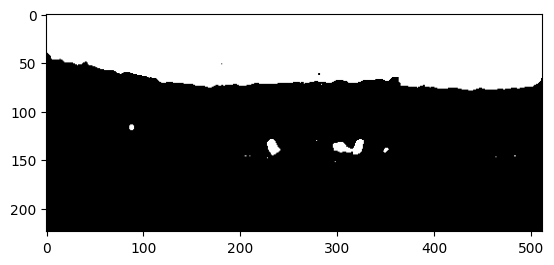

In [15]:
plt.imshow(image == 0, cmap= "gray")

In [16]:
num_class = 10
feature_map_size = 16
num_task = 1
model_path = 'models/'

In [17]:
# Let's create a simpler wrapper
class UNetWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()  # Ensure model is in evaluation mode

    def forward(self, x):
        # Simple forward pass, no need for complex handling
        return self.model(x)

In [19]:
# Load and prepare the model
model = pytorch_unet.UNet(num_class, f_size=feature_map_size, task_no=num_task)
model.load_state_dict(torch.load("/Users/durutandogan/Desktop/unet deneme/models/unet_fold1_run1"))
model.eval()  # Important: set to evaluation mode

# Create the wrapper
wrapped_model = UNetWrapper(model)
wrapped_model.eval()

# Create a valid input tensor
example_input = torch.rand(1, 1, 224, 512)

# Try tracing with more explicit options
with torch.no_grad():  # Make sure we're in no_grad mode for tracing
    traced_model = torch.jit.trace(
        wrapped_model,
        example_input,
        check_trace=False,  # Disable trace checking to avoid potential issues
        strict=False  # Be more lenient with the tracing
    )

    # Verify the traced model works
    test_output = traced_model(example_input)
    print(f"Traced model output type: {type(test_output)}")
    print(f"Traced model output shape: {test_output.shape}")

    # Save the traced model
    traced_model.save("unet_traced.pt")

Forward output type: <class 'torch.Tensor'>
Traced model output type: <class 'torch.Tensor'>
Traced model output shape: torch.Size([1, 10, 224, 512])


Output shape: torch.Size([1, 10, 224, 512])


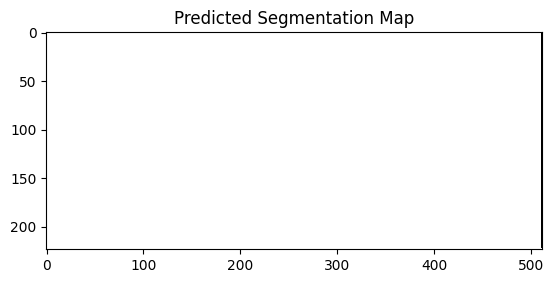

Unique predicted values: [6 9]


In [23]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the traced model
model_path = "/Users/durutandogan/KITE/unet/notebooks/unet_traced.pt"
model = torch.jit.load(model_path)
model.eval()

# Load and prepare an image (same logic as UnetPredictor)
image_path = "/Users/durutandogan/KITE/website/backend/media/Subject_01_21.png"
img = Image.open(image_path).resize((512, 224)).convert('L')
img_array = np.array(img).astype(np.float32) / 255.0
img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]

# Run prediction
with torch.no_grad():
    output = model(img_tensor)

print("Output shape:", output.shape)  # should be [1, 2, 224, 512] or similar

# Visualize the class prediction map
predicted = torch.argmax(output, dim=1).squeeze().cpu().numpy()
plt.imshow(predicted, cmap="gray")
plt.title("Predicted Segmentation Map")
plt.show()

# Optional: Check unique values
print("Unique predicted values:", np.unique(predicted))
